# Quantifying semisc similarity

### Author: Anders Kampenes

### 05-Patch-meaningful-distances-LAND

In [ ]:
### Loading and preparing dataset

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt 
from sklearn.datasets import load_digits 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from scripts.data_utils.plots import scatter, visualize_scatter_with_images,plot_similar_image, plot_similar_image,  plot_random_directions, plot_subset_of_directions  
from scripts.data_utils.generators import SimilarityImageGenerator, generate_directional_dataset, flatten_directional_data
from scripts.data_utils.grid_utils import pad_data_to_fit_patch, blockshaped, unblockshaped, plot_embeddings, create_patched_data, plot_patched_directions

chapterName = "05-Patch-meaningful-distances-LAND"
prevChapterName = "02-data_sequence_analysis_patch"
input_folder = "/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/notebooks/" + prevChapterName
output_folder = "/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/notebooks/" + chapterName
data_cube = np.load("/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/data/processed/f3_entire_int8.npy")

print("img shape", data_cube.shape)

directions, inline_samples, xline_samples, tline_samples,data, labels, num_samples, shape = generate_directional_dataset(data_cube)
#print("labels", labels["inline"], labels["xline"], labels["tline"])
print(shape)


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

img shape (651, 951, 462)
651 951 462
{'inline': [951, 462], 'xline': [651, 462], 'tline': [651, 951]}


In [2]:
# we have now padded all directions and can extract patched of patch_size 
#
patch_size = 64

padded_data = pad_data_to_fit_patch(data, patch_size, directions, num_samples, input_folder)
for dir in directions:
    print("padded_data", padded_data[dir].shape)
    
patched_data, patched_labels, patched_labels_per_image, patched_labels_per_grid_cell, patched_labels_per_grid_cell, patched_grid_sizes, patched_num_smaples =  create_patched_data(padded_data, patch_size, directions)





padding_needed {'inline': 53, 'xline': 9, 'tline': 50}
Found inline
Found xline
Found tline
padded_data (704, 960, 512)
padded_data (960, 704, 512)
padded_data (512, 960, 704)
dir shape (704, 960, 512)
nm 15 8 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84475. 84476. 84477. 84478. 84479.]
patched_labels_per_image[dir] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [703. 703. 703. 703. 703. 703. 703. 703. 703. 703.]
patched_labels_per_grid_cell[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [110. 111. 112. 113. 114. 115. 116. 117. 118. 119.]
dir shape (960, 704, 512)
nm 11 8 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84475. 84476. 84477. 84478. 84479.]
patched_labels_per_image[dir] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [959. 959. 959. 959. 959. 959. 959. 959. 959. 959.]
patched_labels_per_grid_cell[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [78. 79. 80. 81. 82. 83. 8

In [ ]:
### Dimension reduction and visualization with PCA

In [3]:
from sklearn.cluster import KMeans
# flatten directions 
patched_data["inline"] = patched_data["inline"].reshape(patched_grid_sizes["inline"][0], -1)
patched_data["xline"] = patched_data["xline"].reshape(patched_grid_sizes["xline"][0], -1)
patched_data["tline"] = patched_data["tline"].reshape(patched_grid_sizes["tline"][0], -1)
print("flattten dirs", patched_data["inline"].shape, patched_data["xline"].shape, patched_data["tline"].shape )



flattten dirs (84480, 4096) (84480, 4096) (84480, 4096)


In [1]:
# We investigateif a useful distribution can be constructed by replacing the linear distance function with a nonlinear
# counterpart. This is similar in spirit to Isomap [21] that famously replace the linear distance with a
# geodesic distance measured over a neighborhood graph spanned by the data, thereby allowing for
# a nonlinear model. This is, however, a discrete distance measure that is only well-defined over the training data 
# For a generative model, we need a continuously defined metric over the entire feature space 

# Following Hauberg et al. [9] we learn a smoothly changing metric that favors regions of high density i.e., 
# geodesics tend to move near the data. Under this metric, the data space is interpreted as a D-dimensional
# Riemannian manifold. This “manifold learning” does not change dimensionality, but merely provides a local 
# description of the data. 

# First, we construct a metric that captures the nonlinear structure of the data and enables us to compute geodesics


In [4]:
def diagonal_local_pca_metric(data, sigma, rho):
    # Create manfold object
    manifold = {};
    manifold["X"] = data # RxD
    manifold["sigma2"] = sigma**2 # scalar
    manifold["rho"] = rho # scalar
    manifold["dimension"] = data.shape[1] #  scalar

    manifold["class"] = 'diagonal_local_pca_metric'
    return manifold

def isdiagonal (manifold):
    
    # ISDIAGONAL   Determine if a Riemannian metric is diagonal
    #    ISDIAGONAL(manifold) returns true if the Riemannian metric is always
    #    diagonal.

    # Copyright, S?ren Hauberg, 2013

    retval = true;
    return retval 

def metric_tensor(manifold, c, calc_dMdc):
    # This function evaluates the Riemannian metric as well as its derivative.
    #
    # See for details:
    # "A Locally Adaptive Normal Distribution",
    #   G. Arvanitidis, L. K. Hansen, S. Hauberg,
    #   Neural Information Processing Systems (NeurIPS) 2016.
    #
    # Input:
    #   c - point D x N
    #
    # Output:
    #   M    - A matrix NxD, each row has the diagonal elements of the metric.
    #   dMdc - A matrix NxDxD, the M(n,:,j) are the dM(z)/dz_j.
    #
    # Author: Soren Hauberg, Georgios Arvanitidis

    ## Get problem dimensions
    X = manifold["X"] # RxD
    [R, D] = X.shape;
    N = c.shape[1];
    sigma2 = manifold["sigma2"] # scalar
    rho = manifold["rho"] #  scalar

    ##  Handle each point
    M = numpy.empty((N, D))# NxD
    M[:] = numpy.nan
    if calc_dMdc: # Number of function output arguments
        dMdc = np.zeros((N, D, D));


    for n in range(len(N)):
        # Compute metric
        cn = c[:, n] # Dx1
        delta = np.subtract(X, cn.conj().transpose())# RxD
        delta2 = delta**2# RxD
        dist2 = np.sum(delta2, axis=1)# Rx1
        #w_n = exp(-0.5 * dist2 / sigma2) / ((2*pi*sigma2)^(D/2))# Rx1
        #S = (delta.^2).' * w_n + rho# Dx1
        #m = 1 ./ S# Dx1
        #M(n ,:) = m;

        ## Compute derivative of metric?
        #if calc_dMdc: # Number of function output arguments
        #  dSdc = 2 * diag(delta.' * w_n) # DxD
        #  weighted_delta = bsxfun(@times, (w_n ./ sigma2), delta)# RxD
        #  dSdc = dSdc - weighted_delta.' * delta2# DxD
        #  dMdc(n, :, :) = bsxfun(@times, dSdc', m.^2);
        
    #retun [M, dMdc] 


In [5]:
def se_kernel( ell, alpha ):
    # Construct an object of a squared exponential kernel defined as
    #   k(x, y) = alpha * exp( -0.5 (x - y)^2 / ell^2 )
    
    # Prepare the struct.
    gp_kernel = {};
    
    # Keep the lengthscale parameter.
    gp_kernel["ell"] = ell;
    gp_kernel["ell2"] = ell**2;
    
    # Keep the kernel amplitude parameter.
    if alpha:
        gp_kernel["alpha"] = alpha;
    else:
        gp_kernel["alpha"] = 1.0;
    
    gp_kernel["class"] = 'se_kernel' 
    return gp_kernel



In [43]:
def kxy( gp_kernel, x, y ):
    dist2 = (np.c_[x] - np.c_[y].conj().transpose())**2 # N x N
    K = gp_kernel["alpha"] * np.exp(  np.dot(-(0.5 / gp_kernel["ell2"]),dist2) );
    return K
    # TODO IS NP.EXP CORRECT 

def kxdy( gp_kernel, x, y ):
    Kxdy = - kdxy(gp_kernel, x, y)
    return Kxdy

def kxddy( gp_kernel, x, y ):
    Kxddy = -kdxdy(gp_kernel, x, y)
    return Kxddy

def kdxy( gp_kernel, x, y ):

    Kdxy = - delta(gp_kernel, x, y) * kxy(gp_kernel, x, y)
    return Kdxy
    
def delta( gp_kernel, x, y ):

    d = (np.c_[x] - np.c_[y].T) / gp_kernel["ell2"];
    return d

def kdxdy( gp_kernel, x, y ):

    Kdxdy = (1 / gp_kernel["ell2"] - delta(gp_kernel, x, y)**2) * kxy(gp_kernel, x, y);
    return Kdxdy

def kdxddy( gp_kernel, x, y ):

    Kdxddy = - kddxdy(gp_kernel, x, y)
    return Kdxddy

def kddxy( gp_kernel, x, y ):
    Kddxy = -kdxdy(gp_kernel, x, y)
    return Kddxy

def kddxdy( gp_kernel, x, y ):

    Kddxdy = ( - 3 * delta(gp_kernel, x, y) / gp_kernel["ell2"] + delta(gp_kernel, x, y)**3) * kxy(gp_kernel, x, y)
    return Kddxdy
def kddxddy( gp_kernel, x, y ):
    Kddxddy = (delta(gp_kernel, x, y)**4 - 6 * (delta(gp_kernel, x, y)**2) / gp_kernel["ell2"] + 3 / (gp_kernel["ell2"]**2)) * kxy(gp_kernel, x, y)    
    return Kddxddy







In [44]:

import math 
def geodesic_solver_bvp5c(options):
    # This function constructs an object from the specified solver.

    # Initialize the options of the solver
    solver = {};
    solver["options"] = {};

    if "Nmax" in options:
        solver["NMax"] = options["NMax"];
    else:
        solver["NMax"] = 1000;

    if "tol" in options:
        solver["tol"] = options["tol"];
    else:
        solver["tol"] = 1e-1;

    # Initialize the class
    solver["class"] =  'geodesic_solver_bvp5c'
    return solver



def geodesic_solver_fp(D, options):
# This function constructs an object from the specified solver.
#   
# Options:
#   N        - number of mesh points [0,1] including boundaries.
#   tol      - the tolerance of the algorithm.
#   ell      - the length scale.
#   max_iter - the maximum iterations.
#   Sdata    - the amplitude of the kernel.
#   kernel   - the kernel for the GP.
#   sigma    - the std of the noise for the GP parameters.
    
    # If the dimensionality is not given the solver does not work.
    if not D:
        error('Solver dimensionality has not been set...')
    
    # If the default parameters to be used.
    if not options:
        options = [];
    
    # Initialize the solver options
    solver = {}
    solver["options"] = {};
    
    if "N" in options:
        solver["N"] = options["N"];
    else:
        solver["N"] = 10;
    
    if 'tol' in options:
        solver["tol"] = options["tol"];
    else:
        solver["tol"] = 1e-1;
    
    # The mesh size
    T = np.linspace(0, 1, solver["N"]);
    solver["T"] = T;
    
    if 'ell' in options:
        solver["ell"] = options["ell"];
    else:
        solver["ell"] = math.sqrt(0.5*(T[1] - T[0]));
    
    if 'max_iter' in options:
        solver["max_iter"] = options["max_iter"];
    else:
        solver["max_iter"] = 1000;
    
    if 'Sdata' in options:
        solver["Sdata"] = options["Sdata"];
    else:
        print('Kernel amplitude has not been specified!');
        solver["Sdata"] = np.eye(D);
    
    if 'kernel_type' in  options:
        print('Kernel type is not given... ');
    else:
        print('Kernel type has not been specified (default: Squared Exponential).');
        solver["gp_kernel"] = se_kernel(solver["ell"], 1) # ell, alpha (amplitude=1)
    
    # This is the fixed noise of the parameters that we learn during training.
    if 'sigma' in options:
        solver["sigma2"] = options["sigma"]**2;
    else:
        solver["sigma2"] = (1e-4)**2;
    
    # Initialize the object
    solver["class"] = 'geodesic_solver_fp'
    return solver



In [63]:
# for bv5
def compute_geodesic( solver, manifold, c0, c1, solution=None):
    # This function computes the shortest path between two given points on a
    # Riemannian manifold. Details for the fixed point method that is utilized
    # can be found in:
    # "Fast and Robust Shortest Paths on Manifolds Learned from Data",
    #   G. Arvanitidis, S. Hauberg, P. Hennig, M. Schober,
    #   International Conference on Artificial Intelligence and Statistics
    #   (AISTATS) 2019.
    #
    # Input:
    #   solver   - the object from the sovler class.
    #   manifold - An object of any manifold class.
    #   c0, c1   - The given boundary points Dx1.
    #   solution - A struct with the solution of the shortest path.
    #
    # Output:
    #   curve    - A parametric function c(t):[0,1] -> R^D.
    #   logmap   - The logarithmic map Dx1.
    #   len      - The length of the geodesic.
    #   failed   - A boolean, if solver failed this value is true.
    #   solution - The struct containing the details of the solution.
    #
    # Author: Georgios Arvanitidis

    # Get boundary points and ensure column vectors
    c0 = np.c_[c0];
    c1 = np.c_[c1];
    D = c0.shape[0] ; # number of elements in matrix
    print(c0,c1, c1.shape, D)
    # Parameters
    t_min = 0
    t_max = 1 # the boundaries of the interval to integrate [0,1]
    N = solver["N"] # number of points to estimate
    max_iter = solver["max_iter"]# maximum allowed iterations
    ell = solver["ell"]# the length-scale of the kernel
    T = solver["T"].T# N x 1, the discretized time interval [0,1]
    tol = solver["tol"]# algorithm tolerance
    gp_kernel = solver["gp_kernel"]# the GP kernel
    
    # The definition of the GP for curve, dcurve, ddcurve, c0, c1
    
    # ----- Estimate the amplitude of the kernel and define ell
    v = c1 - c0# D x 1
    print("V.T shape", v.conj().transpose().shape)
    print("sData.shae", solver["Sdata"].shape)
    Veta = ((v.conj().transpose() * solver["Sdata"] * v) * solver["Sdata"])# Estimate in Bayesian style the amplitude
    print("Veta.shape", Veta.shape)
    # ----- The prior mean functions
    def m(t):
        c0.conj().transpose() + t * (c1 - c0).conj().transpose() # T x D
    def dm(t): 
        np.ones((t.shape[0], 1)) * (c1 - c0).conj().transpose() # T x D 
    def ddm(t): 
        np.zeros((t.shape[0], 1)) * (c1 - c0).conj().transpose() # T x D
    I_D = np.eye(D)# D x D identity matrix
    print("i_d", I_D.shape)
    
    from scipy.linalg import block_diag
    def R(sigma2): 
        block_diag([sigma2[i] for i  in range(sigma2.shape[0])], I_D * 1e-10, I_D * 1e-10) # The noise block matrix taking in all simga2, D*D and D*D
    
    # ----- The kernel components    
    Ctrain = [kdxddy(gp_kernel, T, T), kdxy(gp_kernel, T, [t_min, t_max]),\
              kxddy(gp_kernel, T, T), kxy(gp_kernel, T, [t_min, t_max])]# 2N x (N+2)
      
    Btrain = [kddxddy(gp_kernel, T, T), kddxy(gp_kernel, T, [t_min, t_max]),\
              kxddy(gp_kernel, [t_min, t_max], T), kxy(gp_kernel, [t_min, t_max], [t_min, t_max])]# (N+2)x(N+2)
     
    # ----- This is the vector where we keep the observations
    y_hat = [ddm(T), m([t_min, t_max])]# Fixed prior mean, (N+2) x D
    def y_obs(ddc):[ddc, c0[:].conj().transpose(), c1[:].conj().transpose()]# (N+2) x D
    
    # ----- The initial guess for the parameters c'' we want to learn
    if solution is None:
        DDC = ddm(T) # N x D
    else:
        # If the geodesic has been solved previously, we will initialize
        # the current parameters with the ones found before.
        if a.size == 0:
            DDC = solution["ddc"];
    
    # ----- Initialize the noise of the GP
    sigma2_blkdiag = np.empty([N, D,D])# N x 1  (every cell DxD)
    print("sigma2_blkdiag", sigma2_blkdiag)
    for n in range(N):
        sigma2_blkdiag[n] = solver["sigma2"] * I_D; 
        
        
        
    print("btain.shapes", kdxddy(gp_kernel, T, T).shape, kdxy(gp_kernel, T, [t_min, t_max]).shape,\
              kxddy(gp_kernel, T, T).shape, kxy(gp_kernel, T, [t_min, t_max]).shape)
    print("Veta", Veta.shape)
    print("(np.kron(Btrain, Veta)", np.kron(Btrain, Veta).shape)
    print("sigma2_blkdiag", sigma2_blkdiag.shape, sigma2_blkdiag[:].shape)
    print("hack", [sigma2_blkdiag[i] for i  in range(sigma2_blkdiag.shape[0])])
    print("NJK", sigma2_blkdiag[0].shape)
    print("R(sigma2_blkdiag))", R(sigma2_blkdiag))
    # ----- The posterior mean of the dcurve & curve with size 2*(N*D) x 1
    Btrain_R_inv = (np.kron(Btrain, Veta) + R(sigma2_blkdiag))# precompute for speed
    #Btrain_R_inv = Btrain_R_inv \ np.eye(size(Btrain_R_inv));
    print("ctain.shapes", kdxddy(gp_kernel, T, T).shape, kdxy(gp_kernel, T, [t_min, t_max]).shape,\
              kxddy(gp_kernel, T, T).shape, kxy(gp_kernel, T, [t_min, t_max]).shape)
    print("Veta", Veta.shape)
    #kronCtrainVeta = kron(Ctrain, Veta);
    #dmu_mu_post = @(t, ddc)vec([dm(t); m(t)]') + kronCtrainVeta * (Btrain_R_inv * vec((y_obs(ddc) - y_hat)'));
    
    #%% The main loop to train z(t_n)'' ~= c''(t_n)
    #iter = 1;
    #tic;
    
    return "curve_bvp5c", "logmap_bvp5c", "len_bvp5c", "failed_bvp5c", "solution_bvp5c"




(200, 2)
[-1.06251904e+00  1.30121054e-16] [1.05376671 0.        ]
{'N': 10}
Kernel amplitude has not been specified!
Kernel type has not been specified (default: Squared Exponential).
solver_fp {'options': {}, 'N': 10, 'tol': 0.1, 'T': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]), 'ell': 0.23570226039551584, 'max_iter': 1000, 'Sdata': array([[1., 0.],
       [0., 1.]]), 'gp_kernel': {'ell': 0.23570226039551584, 'ell2': 0.05555555555555555, 'alpha': 1, 'class': 'se_kernel'}, 'sigma2': 1e-08, 'class': 'geodesic_solver_fp'}
[[-1.06251904e+00]
 [ 1.30121054e-16]] [[1.05376671]
 [0.        ]] (2, 1) 2
V.T shape (1, 2)
sData.shae (2, 2)
Veta.shape (2, 2)
i_d (2, 2)
sigma2_blkdiag [[[2.29175545e-312 2.10077583e-312]
  [2.07955588e-312 2.05833592e-312]]

 [[2.27053550e-312 2.29175545e-312]
  [2.10077583e-312 2.07955588e-312]]

 [[2.05833592e-312 2.27053550e-312]
  [2.29175545e-312 2.10077583e-312]]

 [[2

ValueError: arguments in the following positions have dimension greater than 2: [0]

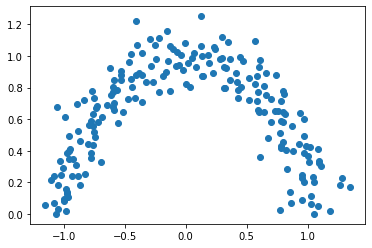

In [64]:
# ================================================ %
# === Non-parametric Riemannian metric example === %
# ================================================ %
#
# A non-parametric Riemannian metric is defined in the space where the data
# lie. Then we are able to compute shortest paths between points by solving 
# the system of nonlinear ordinary differential equations.
# 
# See for details:
# "A Locally Adaptive Normal Distribution",
#   G. Arvanitidis, L. K. Hansen, S. Hauberg,
#   Neural Information Processing Systems (NeurIPS) 2016.
#
# "Latent Space Oddity: on the Curvature of Deep Generative Models",
#   G. Arvanitidis, L. K. Hansen, S. Hauberg,
#   International Conference on Learning Representations (ICLR) 2018.
#
# Author: Georgios Arvanitidis
import scipy.io
mat = scipy.io.loadmat('/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/geometric_ml/data/example1_data_nonparametric.mat')
data = mat["data"]
print(data.shape)
plt.scatter(data[:,0], data[:,1])
# Generate some random data
#N = size(data, 1);

# Here we construct a nonparametric Riemannian metric
sigma_manifold = 0.1;
rho_manifold = 0.01;
#manifold = diagonal_local_pca_metric(data, sigma_manifold, rho_manifold);

manifold = diagonal_local_pca_metric(data, sigma_manifold, rho_manifold)
#print(manifold)


# Pick randomly two points
c0 = data[199,:]
c1 = data[0, :]
print(c0, c1)


# Define the Fixed-Point shortest path solver with default parameters
fp_options = {}
# does not match matplotlib cov(data) so commented out and inited ass np.eye(D9) fp_options["Sdata"] = np.cov(data);
fp_options["N"] = 10;
D = 2;
print(fp_options)
# fp_options.tol = 1e-2;
solver_fp = geodesic_solver_fp(D, fp_options);
print("solver_fp", solver_fp)


# Define the bvp5 solver with default options
bvp5c_options = {};
# bvp5c_options.tol = 1e-3;
solver_bvp5c = geodesic_solver_bvp5c(bvp5c_options);

# Compute the shortest paths (?he bvp5c is initialized with the fp solution).
curve_fp, logmap_fp, len_fp, failed_fp, solution_fp = compute_geodesic( solver_fp, manifold, c0, c1);
#curve_bvp5c, logmap_bvp5c, len_bvp5c, failed_bvp5c, solution_bvp5c = compute_geodesic( solver_bvp5c, manifold, c0, c1, curve_fp);

#metric_tensor = metric_tensor(manifold, c, calc_dMdc)

